In [29]:
import pandas as pd
import numpy as py
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from nltk.corpus import stopwords

%matplotlib inline

In [27]:
#nltk.download_shell()

#### *loading and exploring the data*

In [17]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',
                      names=['label','message'])

In [18]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [20]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [21]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [23]:
messages['length'] = messages['message'].apply(len)

In [24]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


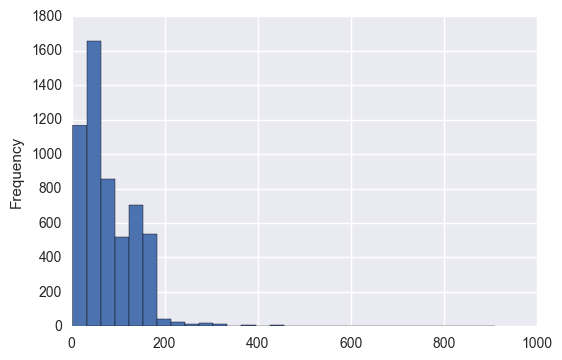

In [25]:
messages['length'].plot.hist(bins=30)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000D31CB7C3C8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000D31DC60D68>], dtype=object)

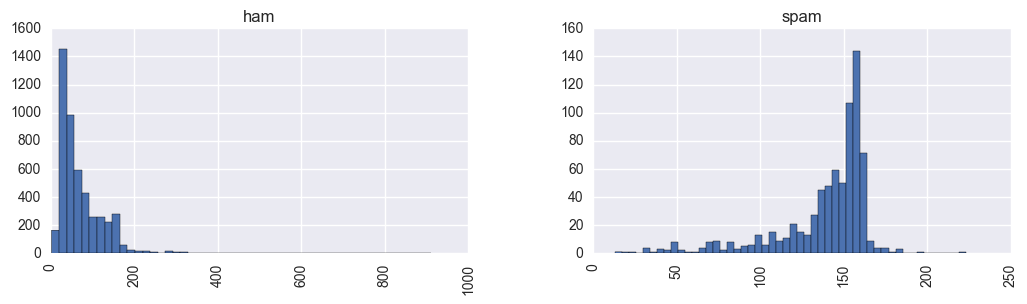

In [26]:
messages.hist(column='length',by='label',bins=50,figsize=(12,3))

#### *Text pre-processing*

In [38]:
def text_process(mess):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of clean text words
    """
    
    nopunc = [char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower not in stopwords.words('english')] 

In [39]:
from sklearn.feature_extraction.text import CountVectorizer 

In [40]:
bag_of_words_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [41]:
messages_bow = bag_of_words_transformer.transform(messages['message'])

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer

In [43]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [44]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [45]:
from sklearn.naive_bayes import MultinomialNB

In [46]:
spam_detect_model = MultinomialNB().fit(messages_tfidf,messages['label'])

#### *Train Test Split*

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
msg_train,msg_test,label_train,label_test = train_test_split(messages['message'],messages['label'],test_size=0.3)

#### *Data Pipeline*

In [49]:
from sklearn.pipeline import Pipeline

In [50]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [51]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000000D31E201268>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [52]:
predictions = pipeline.predict(msg_test)

#### *Evaluating the model*

In [53]:
from sklearn.metrics import classification_report

In [54]:
print(classification_report(label_test,predictions))

             precision    recall  f1-score   support

        ham       0.94      1.00      0.97      1451
       spam       1.00      0.60      0.75       221

avg / total       0.95      0.95      0.94      1672

